In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
df = pd.read_csv("scaled_final_data.csv", parse_dates=["Date"])

# Sort data to maintain time order
df = df.sort_values(by="Date").reset_index(drop=True)

# Display dataset preview
print(df.head())
print(f"Dataset Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Define feature columns (excluding 'Date' and 'Close')
feature_cols = [col for col in df.columns if col not in ["Date", "Close"]]

# Convert to numpy arrays
X_data = df[feature_cols].values
y_data = df["Close"].values

# Check feature & target shape
print(f"Feature Shape: {X_data.shape}, Target Shape: {y_data.shape}")

# Function to create LSTM sequences
def create_sequences(data, target, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 10
X_seq, y_seq = create_sequences(X_data, y_data, seq_length)

# Check shape
print(f"X_seq Shape: {X_seq.shape}, y_seq Shape: {y_seq.shape}")

# Define train-test split (80-20)
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"Train-Test Split Done: {X_train.shape[0]} train, {X_test.shape[0]} test")

# Define batch size
batch_size = 32

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"DataLoaders Ready")




        Date      Close      High       Low      Open    Volume    SMA_20  \
0 2019-03-14  88.665054 -1.371397 -1.345120 -1.374313 -0.407346 -1.381181   
1 2019-03-15  89.683525 -1.350454 -1.327536 -1.353680  1.606886 -1.376367   
2 2019-03-18  90.222214 -1.328161 -1.298535 -1.327832 -0.115914 -1.374456   
3 2019-03-19  89.893936 -1.314425 -1.297393 -1.290422 -0.122616 -1.372567   
4 2019-03-20  87.974861 -1.353832 -1.346262 -1.330553  0.172065 -1.373931   

     SMA_50    EMA_20    RSI_14  ...  embed_758  embed_759  embed_760  \
0 -1.429985 -1.396149  0.426552  ...   0.836308  -0.388102  -1.142466   
1 -1.426070 -1.390768  0.877815  ...   0.836308  -0.388102  -1.142466   
2 -1.421162 -1.384474  1.084134  ...   0.836308  -0.388102  -1.142466   
3 -1.418188 -1.379649  0.837523  ...   0.836308  -0.388102  -1.142466   
4 -1.416357 -1.380359 -0.318624  ...   0.836308  -0.388102  -1.142466   

   embed_761  embed_762  embed_763  embed_764  embed_765  embed_766  embed_767  
0   2.785554  -1.

In [6]:
import torch.nn as nn
import torch.optim as optim

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Take last output of sequence

# Initialize model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = LSTMModel(X_train.shape[2]).to(device)

print(f"Model initialized on {device}")


Model initialized on mps


In [ ]:
import torch.optim as optim
import pickle
from torch.utils.data import DataLoader, TensorDataset

# Prepare DataLoader
batch_size = 64  # Increase batch size for stability
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # Use AdamW for better stability

# Learning rate scheduler (ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)

# Training Configuration
epochs = 1000
best_loss = float("inf")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()

        # Apply gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")
    
    # Adjust learning rate based on validation loss
    scheduler.step(epoch_loss)
    
    # Save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), "lstm_model_best.pth")
        torch.save(optimizer.state_dict(), "lstm_optimizer_best.pth")
        print(f"Model saved at epoch {epoch+1} with best loss {best_loss:.6f}")

print("LSTM Training Complete")


In [5]:
# Load trained LSTM model
model.load_state_dict(torch.load("lstm_model_best.pth", map_location=device))
model.eval()

print("LSTM Model Loaded Successfully!")


LSTM Model Loaded Successfully!


/var/folders/bl/qygrpx515yn2jk1zq7j95d_80000gp/T/ipykernel_1741/3018076157.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lstm_model_b

In [7]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Convert test data to device
X_test_tensor = X_test_tensor.to(device)

# Make predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert predictions back to numpy
y_pred = y_pred_tensor.cpu().numpy().flatten()
y_true = y_test_tensor.cpu().numpy().flatten()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Compute Directional Accuracy
direction_true = np.sign(np.diff(y_true))  # +1 if price goes up, -1 if down
direction_pred = np.sign(np.diff(y_pred))  # Model's predicted direction

# Compute Accuracy as % of correctly predicted movements
accuracy = accuracy_score(direction_true, direction_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy (Trend Prediction): {accuracy * 100:.2f}%")


Test MSE: 40334.3594
Spearman Correlation: -0.3439
R² Score: -45.2362
Directional Accuracy (Trend Prediction): 13.55%


In [13]:
from sklearn.preprocessing import StandardScaler

# Reload original dataset (before scaling)
df_original = pd.read_csv("rolling_news_data.csv", parse_dates=["Date"])

# Fit a scaler only on the 'Close' column
scaler = StandardScaler()
df_original["Close"] = scaler.fit_transform(df_original[["Close"]])  # Fit on original Close prices

# ONLY inverse transform predictions, keep actual values unchanged
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Print corrected predictions
for i in range(10):
    print(f"Actual: {y_true[i]:.2f}, Predicted: {y_pred_original[i]:.2f}")




Actual: 141.77, Predicted: 141.65
Actual: 141.77, Predicted: 141.53
Actual: 141.77, Predicted: 140.65
Actual: 141.17, Predicted: 140.46
Actual: 141.17, Predicted: 140.31
Actual: 141.17, Predicted: 140.24
Actual: 141.17, Predicted: 140.41
Actual: 138.90, Predicted: 140.71
Actual: 138.90, Predicted: 140.66
Actual: 137.00, Predicted: 140.62


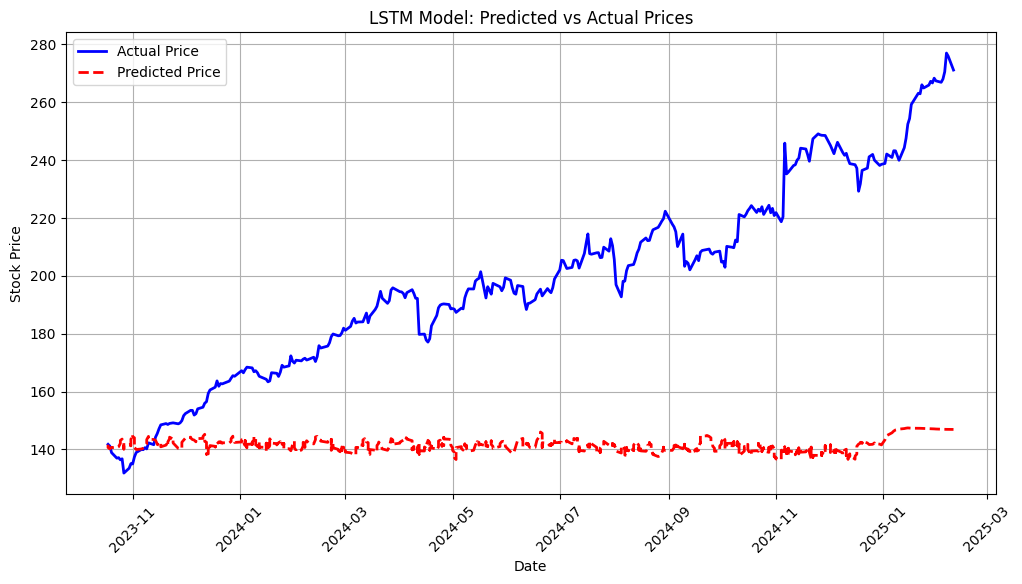

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, y_true, label="Actual Price", color="blue", linewidth=2)  # Keep actual values
plt.plot(dates, y_pred_original, label="Predicted Price", color="red", linestyle="dashed", linewidth=2)  # Inverse transformed predictions

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Model: Predicted vs Actual Prices")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


In [17]:
import numpy as np

# Check min-max values of predictions & actuals
print(f"🔹 Actual Price Range: Min={np.min(y_true)}, Max={np.max(y_true)}")
print(f"🔹 Predicted Price Range: Min={np.min(y_pred_original)}, Max={np.max(y_pred_original)}")

# Compute mean and std of actual & predicted values
actual_mean, actual_std = np.mean(y_true), np.std(y_true)
predicted_mean, predicted_std = np.mean(y_pred_original), np.std(y_pred_original)

print(f"📊 Actual Mean: {actual_mean:.2f}, Std Dev: {actual_std:.2f}")
print(f"📉 Predicted Mean: {predicted_mean:.2f}, Std Dev: {predicted_std:.2f}")



🔹 Actual Price Range: Min=131.8444366455078, Max=276.8999938964844
🔹 Predicted Price Range: Min=136.5180206298828, Max=147.43569946289062
📊 Actual Mean: 198.71, Std Dev: 29.54
📉 Predicted Mean: 141.06, Std Dev: 1.84
